In [1]:
import numpy as np
from matplotlib import pyplot as plt

## <b>My understanding portion

### Helper Plotter function

In [2]:
def scatter_plotter(x_data, y_data):
    plt.figure(figsize=(8,6))
    plt.tight_layout()
    plt.scatter(x_data, y_data, s=10, c='violet', edgecolors='black', linewidths=1)
    plt.show()

### Parameters for dataset creation

In [3]:
data_params = { 'ntrials': 2000,
                'tsteps': 300,
                'dt': 0.01,
                'input_dim': 7,
                'output_dim': 4,
                'vel': 10,
                'p_test': 0.1,
                'go_to_peak': 50,
                'stim_on': 20,
                'random': {'output_range': [-6, 6], 'go_range': [70, 220]},
                'center-out-reach': {'output_range': 5,'ntargets': 8, 'go_range': [170, 220]}}


### Some Test snippets

In [4]:
# # PARAMS #################################
# ntrials = data_params['ntrials'] #2000
# tsteps = data_params['tsteps'] # 300
# dt = data_params['dt'] # 0.01
# input_dim = data_params['input_dim'] # 7
# output_dim = data_params['output_dim'] # 4
# vel = data_params['vel'] # 10
# p_test = data_params['p_test'] # 0.1
# go_to_peak = data_params['go_to_peak'] # 50
# stim_on = data_params['stim_on'] # 20

#     # random reach dataset params
# output_range = data_params['random']['output_range'] # -6,6
# go_range = data_params['random']['go_range'] # 70,220
# ##########################################

# # create artifical data
# start_point = np.random.uniform(output_range[0],output_range[1],(ntrials,2)) # uniform random numbers between -6,6 of shape (2000,2)
# end_point = np.random.uniform(output_range[0],output_range[1],(ntrials,2)) # uniform random numbers between -6,6 of shape (2000,2)
# go_on = np.random.uniform(go_range[0],go_range[1],ntrials).astype(int) # uniform random numbers between 70, 220 of shape (2000,)

# print(go_on.mean())
# # print(f"output_range = {go_range[0]}, {go_range[1]}")

In [5]:
# start_point[0]
# end_point[0]

In [6]:
# x, y = [], []
# for i in range(len(start_point)):
#     x.append(start_point[i][0])
#     y.append(start_point[i][1])
# scatter_plotter(x,y)


In [7]:
# ntrials = start_point.shape[0] #ntrials = 2000

# # sigmoid function for data
# def sig(x,beta):
#     return 1/(1+np.exp(-x*beta))

# # prepare xaxis for smooth transition
# xx = np.linspace(-1,1,100,endpoint=False) # 100 points between -1 and 1
# ytemp = sig(xx,vel) # 100 points between 0 to 1, 
# print(ytemp.shape)

# plt.plot(xx, ytemp)

## <b>Actual Data preparation portion

### Some Snippets for understanding the generated data

In [8]:
# # Toy for understanding
# target = np.zeros((2,tsteps,output_dim)) # 2 x 300 x 4
# print(target.shape)

# target[0,:(150+go_to_peak),:2] = start_point[0]
# tt= target[0]

# target[0,(150+go_to_peak):,:2] = end_point[0]
# tt = target[0]

# print(end_point[0]-start_point[0])

# target[0,(150-go_to_peak):(150+go_to_peak),:2] += \
#                 ytemp[:,None]*(end_point[0]-start_point[0])[None,:]
# tt = target[0]

# target[0,:,2:] = np.gradient(target[0,:,:2],dt,axis=1)
# tt = target[0]

In [9]:
# # toy for understanding 

# stimulus = np.zeros((2,tsteps,input_dim)) # 2 x 300 x 7
# print(stimulus.shape)

# # loading the velocity
# stimulus[:,:,3:5] = target[:,:,2:]
# tx = stimulus[0]

# # loading the position
# stimulus[:,:,5:] = target[:,:,:2]
# tx = stimulus[0]

# # loading the endpoint-startpoint values (after stim_on rows)
# stimulus[0,stim_on:,:2] = end_point[0]-start_point[0] # visible endpoint position signal
# tx = stimulus[0]

# # loading hold signal from beginnning until (go_on-go_to_peak) rows
# stimulus[0,:(150-50),2] = 43 # hold signal
# tx = stimulus[0]

### Function to prep data

In [31]:
def _prepare_data(start_point,end_point,go_on,vel,tsteps,input_dim,
                  output_dim,dt,stim_range,go_to_peak,stim_on,transition=1):
    """
    Prepare data for RNN training by generating target and stimulus arrays.
    Parameters:
    start_point (np.ndarray): Starting points for each trial, shape (ntrials, 2).
    end_point (np.ndarray): Ending points for each trial, shape (ntrials, 2).
    go_on (np.ndarray): Time steps at which the transition starts for each trial, shape (ntrials,).
    vel (float): Velocity parameter for the sigmoid function.
    tsteps (int): Total number of time steps.
    input_dim (int): Dimensionality of the input data.
    output_dim (int): Dimensionality of the output data.
    dt (float): Time step duration.
    stim_range (float): Range of the stimulus. Hold Signal. Used as output_range[1]
    go_to_peak (int): Number of time steps to reach the peak.
    stim_on (int): Time step at which the stimulus is turned on.

    Returns:
    tuple: A tuple containing:
        - target (np.ndarray): Target data for each trial, shape (ntrials, tsteps, output_dim).
            first two dimensions are the position, last two dimensions are the velocity
            !it is target data for every time bin, not just the endpoint
        - stimulus (np.ndarray): Stimulus data for each trial, shape (ntrials, tsteps, input_dim).
            dim [5-6] = first two dimensions of target mvt (so position)
            dim [3-4] = last two dimensions of target mvt (so velolcity)
            dim [0-1] = beforfe stim_on it is zero, after stim_on it is end_point-start_point
            dim 2 = before go_on[k]-go_to_peak = 0, after = stim_range (hold signal)
    """

    # start point = (ntrials x 2), here 2000 x 2
    ntrials = start_point.shape[0] #ntrials = 2000

    # sigmoid function for velocity scaling
    def sig(x,beta):
        return 1/(1+np.exp(-x*beta))
    
    # prepare xaxis for smooth transition
    xx = np.linspace(-1,1,100,endpoint=False) # 100 points between -1 and 1
    
    # yaxis prepared using sigmoid, veloctiy squished from 10 to [0,1]
    ytemp = sig(xx,vel) #100 points between 0 and 1
    
    # create target, at first initialize with 0
    # first two columns are postions
    # last two columns are velocity
    target = np.zeros((ntrials,tsteps,output_dim)) # 2000 x 300 x 4

    for j in range(ntrials):
        # for each trial, set first two columns from row 0 to row (go_on[j] + go_to_peak) as start_point[j] 
        target[j,:(go_on[j]+go_to_peak),:2] = start_point[j]
        # for each trial, set first two columns from row(go_on[j] + go_to_peak) to the last row as end_point[j] 
        target[j,(go_on[j]+go_to_peak):,:2] = end_point[j]  
        # for each trial, set first 2 columns from row (go_on[j]-go_to_peak) to (go_on[j]+go_to_peak) as the "formula"
        # this is the "trajectory" ??
        if transition:
            target[j,(go_on[j]-go_to_peak):(go_on[j]+go_to_peak),:2] += \
                ytemp[:,None]*(end_point[j]-start_point[j])[None,:]
    
    # add target velocity
    target[:,:,2:] = np.gradient(target[:,:,:2],dt,axis=1)
    
    # create stimulus
    stimulus = np.zeros((ntrials,tsteps,input_dim))

    #just copy pasting the "target" array into the last 4 columns of this array
    #careful about the ordering 

    stimulus[:,:,3:5] = target[:,:,2:].copy()
    stimulus[:,:,5:] = target[:,:,:2].copy()
    for j in range(ntrials):
        # first two columns are endpoints - start point. Filled after "stim_on" rows
        stimulus[j,stim_on:,:2] = end_point[j]-start_point[j] # visible endpoint position signal

        # 3rd column, it is filled with hold signal (the output_dim[1] or 6 in Random reach)
        # so 34d column is filled with 6 from row 0 to row (go_on[j]-go_to_peak) 
        stimulus[j,:(go_on[j]-go_to_peak),2] = stim_range # hold signal
    return target,stimulus # target shape is (ntrials, 300, 4), stimulus shape is (ntrials, 300, 7)


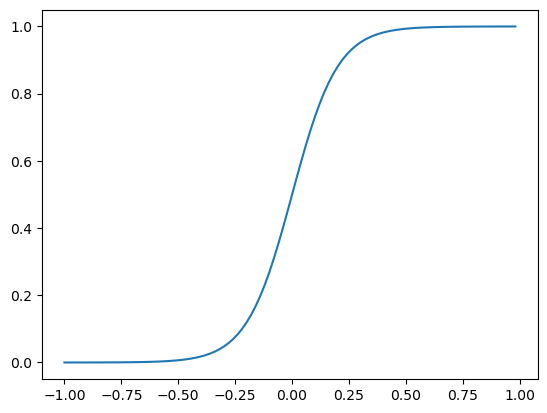

In [32]:
vel = 10
def sig(x,beta):
    return 1/(1+np.exp(-x*beta))
xx = np.linspace(-1,1,100,endpoint=False)
ytemp = sig(xx,vel)
plt.plot(xx,ytemp)

In [33]:
# arr2d = np.array([[1, 2], [3, 5], [6, 10]])
# print(arr2d)
# x = np.gradient(arr2d,0.01, axis=1)
# x

### Function to create dataset 1

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
def create_data_velocity_random(data_params):
    # PARAMS #################################
    ntrials = data_params['ntrials'] #2000
    tsteps = data_params['tsteps'] # 300
    dt = data_params['dt'] # 0.01
    output_dim = data_params['output_dim'] # 4
    input_dim = data_params['input_dim'] # 7
    vel = data_params['vel'] # 10
    p_test = data_params['p_test'] # 0.1
    go_to_peak = data_params['go_to_peak'] # 50
    stim_on = data_params['stim_on'] # 20
    output_range = data_params['random']['output_range'] # -6,6
    go_range = data_params['random']['go_range'] # 70,220
    ##########################################
    
    # create artifical data
    start_point = np.random.uniform(output_range[0],output_range[1],(ntrials,2)) # uniform random numbers between -6,6 of shape (2000,2)
    end_point = np.random.uniform(output_range[0],output_range[1],(ntrials,2)) # uniform random numbers between -6,6 of shape (2000,2)
    go_on = np.random.uniform(go_range[0],go_range[1],ntrials).astype(int) # 2000 random numbers between 70 and 220, transition start time
    
    print(output_range[1])
    target,stimulus = _prepare_data(start_point, 
                                    end_point, 
                                    go_on, 
                                    vel, 
                                    tsteps,
                                    input_dim,
                                    output_dim,
                                    dt,
                                    output_range[1],
                                    go_to_peak,
                                    stim_on)

    # create testset
    test_idx = np.random.rand(ntrials)<p_test
    print(len(test_idx))

    test_set = {'target':target[test_idx],'stimulus':stimulus[test_idx],
                 'peak_speed':go_on[test_idx]}
    train_idx = test_idx==False
    
    # save it
    data = {'params':data_params,'target':target[train_idx],
           'peak_speed':go_on[train_idx],'stimulus':stimulus[train_idx],
           'test_set':test_set}
    
    print('RANDOM REACH DATASET CONSTRUCTED!')
    return data

6
2000
RANDOM REACH DATASET CONSTRUCTED!
Training trails = 1807


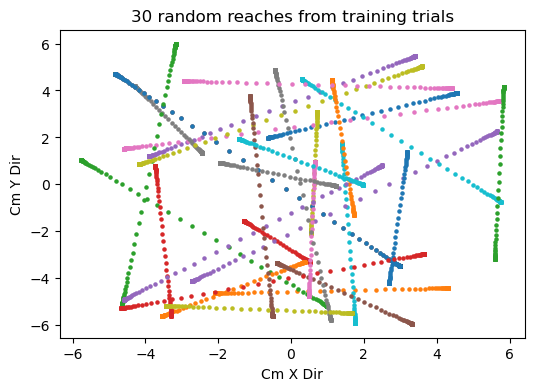

In [36]:
x = create_data_velocity_random(data_params)
x.keys()
stim = x['stimulus']
targ = x['target']

print(f"Training trails = {len(x['stimulus'])}")

plt.figure(figsize=(6,4))
for i in range(30):
    trial = np.random.randint(0,len(x['stimulus']))
    stim_1 = stim[trial]
    px = stim_1[:,5]
    py = stim_1[:,6]
    plt.scatter(px,py, s=5, lw=1)
    plt.title("30 random reaches from training trials")
    plt.xlabel("Cm X Dir")
    plt.ylabel("Cm Y Dir")
plt.show()

### Function to create dataset 2

In [37]:
def create_data_velocity_centeroutreach(data,transition=1):
    # PARAMS #################################
    ntrials = data['ntrials']
    tsteps = data['tsteps']
    dt = data['dt']
    output_dim = data['output_dim']
    input_dim = data['input_dim']
    vel = data['vel']
    p_test = data['p_test']
    go_to_peak = data['go_to_peak']
    stim_on = data['stim_on']
    output_range = data['center-out-reach']['output_range']
    go_range = data['center-out-reach']['go_range']
    ntargets = data['center-out-reach']['ntargets']
    ##########################################
    
    # create artifical data
    start_point = np.zeros((ntrials,2))
    phi = np.linspace(0,2*np.pi,ntargets,endpoint=False)
    tids = np.random.choice(range(ntargets),ntrials)
    end_point = (output_range*np.array([np.cos(phi[tids]),np.sin(phi[tids])])).T
    go_on = np.random.uniform(go_range[0],go_range[1],ntrials).astype(int)
    
    target,stimulus = _prepare_data(start_point, end_point, go_on, vel, tsteps,
                                    input_dim,output_dim,dt,output_range,
                                    go_to_peak,stim_on,transition=transition)

    # create testset
    test_idx = np.random.rand(ntrials)<p_test
    test_set = {'target':target[test_idx],'stimulus':stimulus[test_idx],
                 'peak_speed':go_on[test_idx],'tids':tids[test_idx]}
    train_idx = test_idx==False
    
    # save it
    data = {'params':data,'target':target[train_idx],
           'peak_speed':go_on[train_idx],'stimulus':stimulus[train_idx],
           'test_set':test_set,'tids':tids[train_idx]}
    
    print('CENTER OUT REACH DATASET CONSTRUCTED!')
    return data


In [38]:
print(targ.shape)
#targ[5,:,1]

(1807, 300, 4)


CENTER OUT REACH DATASET CONSTRUCTED!
Training trials = 1779


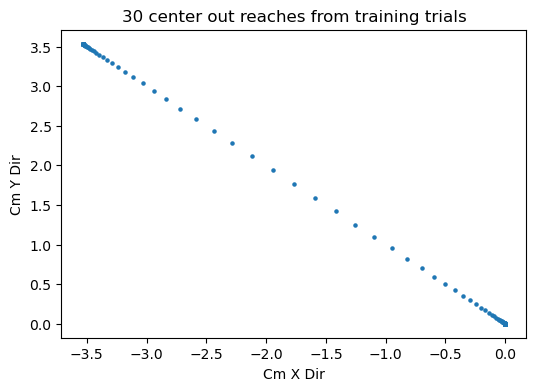

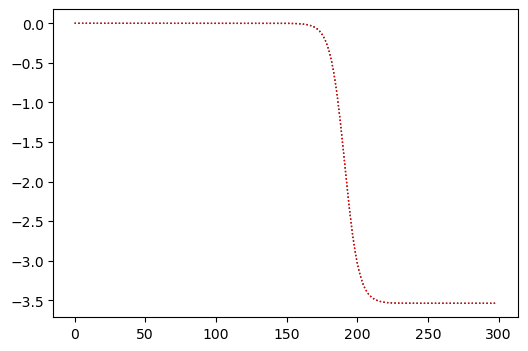

In [46]:
x = create_data_velocity_centeroutreach(data_params,transition=1)

stim = x['stimulus']
targ = x['target']

print(f"Training trials = {len(x['stimulus'])}")

plt.figure(figsize=(6,4))
for i in range(12,13):
    trial = np.random.randint(0,len(x['stimulus']))
    stim_1 = stim[trial]
    plt.scatter(stim_1[:,5],stim_1[:,6], s=5, lw=1)
    plt.title("30 center out reaches from training trials")
    plt.xlabel("Cm X Dir")
    plt.ylabel("Cm Y Dir")
plt.show()

#px,py = stim_1[:,5],stim_1[:,6]
tpx,tpy = targ[i,:,0],targ[i,:,1]
# plt.figure(figsize=(6,4))
# plt.plot(px  ,lw=1, c= 'k')
# plt.plot(py , lw=1, c='red')

plt.figure(figsize=(6,4))
plt.plot(tpx  ,lw=1, c= 'k',ls=':')
plt.plot(tpy , lw=1, c='red',ls=':')

### Function to create random perturbation

In [16]:
def perturb(tdat,batch_size,dpert):
    '''
    generate trajectory _velocity_ perturbations 

    dpert is a dictionary with the following keys (example)
    dpert = {'pratio':0.5 -- ratio of trajectories recieveing perturbation,
             'halflength':10, -- num of timebins of perturbation (velocity bump)
             'from':20,
             'upto':200,
             'amp':10}
    '''
    pratio = dpert['pratio']
    halflength = dpert['halflength']
    for i in range(batch_size):
        # run random twice to perturn first or sedond coordinate
        for coordi in [0,1]:
            if np.random.rand()<pratio:
                tmp = int(np.random.choice(range(dpert['from'],dpert['upto'],1),1)[0])
                tdat[(tmp-halflength):(tmp+halflength),i,coordi] = dpert['amp']

        # if np.random.rand()<pratio:
        #     tmp = int(np.random.choice(range(dpert['from'],dpert['upto'],1),1)[0])
        #     tdat[(tmp-halflength):(tmp+halflength),i,0] = dpert['amp']
        # if np.random.rand()<pratio:
        #     tmp = int(np.random.choice(range(dpert['from'],dpert['upto'],1),1)[0])
        #     tdat[(tmp-halflength):(tmp+halflength),i,1] = dpert['amp']
    return tdat

In [17]:
idx = np.random.choice(1802,20,replace=False)
idx

array([ 560,   90, 1100, 1116, 1303,  475,  262, 1321,  782,  383,  357,
        501,   65,   28, 1079,  209,  541,  595,   93,  650])